In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install geometric_kernels

# If you want to use a version of the library from a specific branch on GitHub,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/geometric-kernels/GeometricKernels@devel"

# Matérn and Heat Kernels on the Special Unitary Group $\mathrm{SU}(n)$

This notebook shows how define and evaluate kernels on the special unitary group $\mathrm{SU}(3)$ that consists of $3 \times 3$ unitary matrices with unit determinant. **Note**: the entries of these matrices are complex numbers.

Handling the special unitary group $\mathrm{SU}(n)$ for $n \geq 2$, $n \not= 3$ is the same.
Our choice of $\mathrm{SU}(3)$ here is rather arbitary

**Note:** the "points" in the special unitary group $\mathrm{SU}(n)$ are represented by matrices (`array`s of the suitable backend) in $\mathbb{C}^{n \times n}$ whose determinant is equal to $1$.

We use the **numpy** backend here.

<!--TABLE OF CONTENTS-->
## Contents
- [**Basics**](#Basics)
  - [Defining a Space](#Defining-a-Space)
  - [Defining a Kernel](#Defining-a-Kernel)
  - [Evaluating Kernels on Random Inputs](#Evaluating-Kernels-on-Random-Inputs)
  - [Visualize Kernels](#Visualize-Kernels)
- [**Feature Maps and Sampling**](#Feature-Maps-and-Sampling)
  - [Defining a Feature Map](#Defining-a-Feature-Map)
  - [Efficient Sampling using Feature Maps](#Efficient-Sampling-using-Feature-Maps)
- [**Citation**](#Citation)

## Basics

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np

# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import SpecialUnitary
from geometric_kernels.kernels import MaternGeometricKernel

from opt_einsum import contract as einsum

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.


### Defining a Space

First we create a GeometricKernels `space` that corresponds to the special unitary group $\mathrm{SU}(3)$, a subset of the set of all $3 \times 3$ matrices $\mathbb{C}^{3 \times 3}$.

In [3]:
su = SpecialUnitary(n=3)

### Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternGeometricKernel` you just need to provide a `Space` object, in our case this is the `su` we have just created above.

There is also an optional second parameter `num` which determines the order of approximation of the kernel.
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on compact manifold like (which $\mathrm{SU}(n)$ are examples of) can be found on these documentation pages: [one](https://geometric-kernels.github.io/GeometricKernels/theory/compact.html), [two](https://geometric-kernels.github.io/GeometricKernels/theory/addition_theorem.html).

In [4]:
kernel = MaternGeometricKernel(su)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not provide the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [5]:
params = kernel.init_params()
print('params:', params)

params: {'nu': array(inf), 'lengthscale': array(1.)}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [6]:
params["lengthscale"] = np.array([0.5])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

### Evaluating Kernels on Random Inputs

We start by sampling `10` (uniformly) random points in $\mathrm{SU}(3)$.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [7]:
key = np.random.RandomState(1234)

key, xs = su.random(key, 10)

print(xs)

[[[-0.24870157+0.29658916j -0.5727367 -0.11896851j
    0.13530366-0.69978174j]
  [ 0.5363398 +0.02093302j -0.65531723+0.08089576j
    0.33398574+0.40542589j]
  [-0.11099553+0.74146059j  0.29052499+0.37071498j
    0.44367674+0.13868223j]]

 [[-0.40611116+0.68674043j -0.24739267+0.08064182j
    0.53529265+0.09600445j]
  [ 0.26710651-0.26169472j -0.83907273+0.34164848j
    0.06551645+0.18737889j]
  [ 0.45063037+0.1434j      0.32339163+0.08333599j
    0.15110962+0.80125374j]]

 [[-0.13732798+0.60690315j -0.52886472-0.48536215j
   -0.28540059-0.12681398j]
  [ 0.3977959 -0.4922283j  -0.10684889-0.65678461j
   -0.09403321+0.38450588j]
  [ 0.28915018+0.35870808j  0.04449183-0.19990863j
    0.86256719+0.04189913j]]

 [[ 0.38533066-0.816148j    0.22140522-0.1918158j
   -0.25677676+0.18350706j]
  [ 0.03489247-0.16093316j  0.2272763 -0.38032158j
    0.55442717-0.68497775j]
  [-0.02006891+0.39737009j  0.36597823-0.76416447j
   -0.19967803+0.28971629j]]

 [[-0.04247357+0.18109435j -0.18802367-0.0778

Now we evaluate the two kernel matrices.

In [8]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

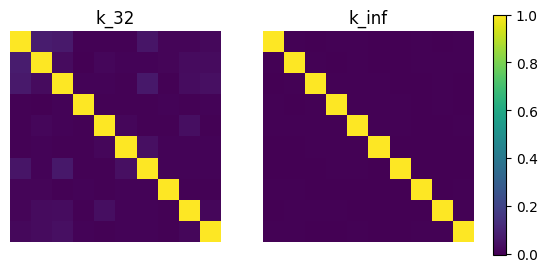

In [9]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

### Visualize Kernels

It is hard to visualize functions on $\mathrm{SU}(n)$.
Why so?
Well, we have $\dim \left(\mathrm{SU}(n)\right) = n^2-1$, thus even $\dim \left(\mathrm{SU}(2)\right) = 3$ is greater than $2$.
Functions are only easy to visualize on domains with dimension not higher than $2$.

To get some understanding of how kernels and samples of Gaussian processes on $\mathrm{SU}(n)$ look like, we will do something like visualizing $f: \mathbb{R}^n \to \mathbb{R}$ by examining the plots of $\alpha \to f(\alpha \mathbf{v})$ for random vectors $\mathbf{v}$. In our case, we will take a random matrix $\mathbf{U} \in \mathrm{SU}(n)$ and visualize functions $\alpha \to f(\mathbf{U}^{*} \mathbf{E}(\alpha) \mathbf{U})$ where $\alpha \in [0, 2 \pi)$, $\mathbf{U}^{*}$ is the conjugate transpose of $\mathbf{U}$ and
$$
\mathbf{E}(\alpha)
=
\begin{bmatrix} 
    e^{i \alpha} & 0             & \dots  & 0     \\
    0            & e^{-i \alpha} & \dots  & 0     \\
    \vdots       & 0             & \ddots & \vdots\\
    0            & 0             & \dots  & 1     \\
\end{bmatrix}
$$
is an embedding of the one-dimensional rotation group $\mathrm{SO}(2)$ (which can be regarded as the circle $\mathbb{T}$ or the unitary group $\mathrm{U}(1)$) into $\mathrm{SU}(n)$.
Intuitively, this corresponds to rotating by angle $\alpha$ around a random axis in $\mathbb{R}^n$.
To better reflect the structure of $\alpha$, we will actually treat it as a point on the circle, rather than an angle.

We will plot the functions $k_{\nu, \kappa}(\mathbf{I}, \mathbf{U}^{\top} \mathbf{E}(\alpha) \mathbf{U})$.

In practice, we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points1` or $x \in $ `other_points2`.
The `base_point` is simply the identity matrix $\mathbf{I}$.
The `other_points1` and `other_points2` are defined by the `_NUM_ANGLES` uniform discretization of the unit circle.

We define `base_point`, `other_points`, and `other_points2` in the next cell.

In [10]:
# define discretization
_NUM_ANGLES = 128

key, U = su.random(key, 2)
U1 = U[0, :]
U2 = U[1, :]

# generate a grid on [0, 2 \pi)
angles = np.linspace(0, 2*np.pi, num=_NUM_ANGLES)
embedding = np.broadcast_to(np.eye(3, dtype=np.complex128), (_NUM_ANGLES, 3, 3)).copy()
embedding[:, 0, 0] = np.exp(1j*angles)
embedding[:, 1, 1] = np.exp(-1j*angles)

base_point = embedding[[0], :, :]

def conj_batch(U, emb):
    """ Compute U^T * emb[i, :] * U for all i.
    :param U:   [3, 3] array
    :param emb: [N, 3, 3] array
    
    :return:    [N, 3, 3] array
    """
    return einsum('ij,njk,kl->nil', U, emb, np.conjugate(U).T)

other_points1, other_points2 = conj_batch(U1, embedding), conj_batch(U2, embedding)

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points1` and $x \in $ `other_points2`, for $\nu$ either $3/2$ or $\infty$.

In [11]:
kernel_vals_32_1  = kernel.K(params_32,  base_point, other_points1)
kernel_vals_32_2  = kernel.K(params_32,  base_point, other_points2)
kernel_vals_inf_1 = kernel.K(params_inf, base_point, other_points1)
kernel_vals_inf_2 = kernel.K(params_inf, base_point, other_points2)

Finally, we are ready to plot the results.

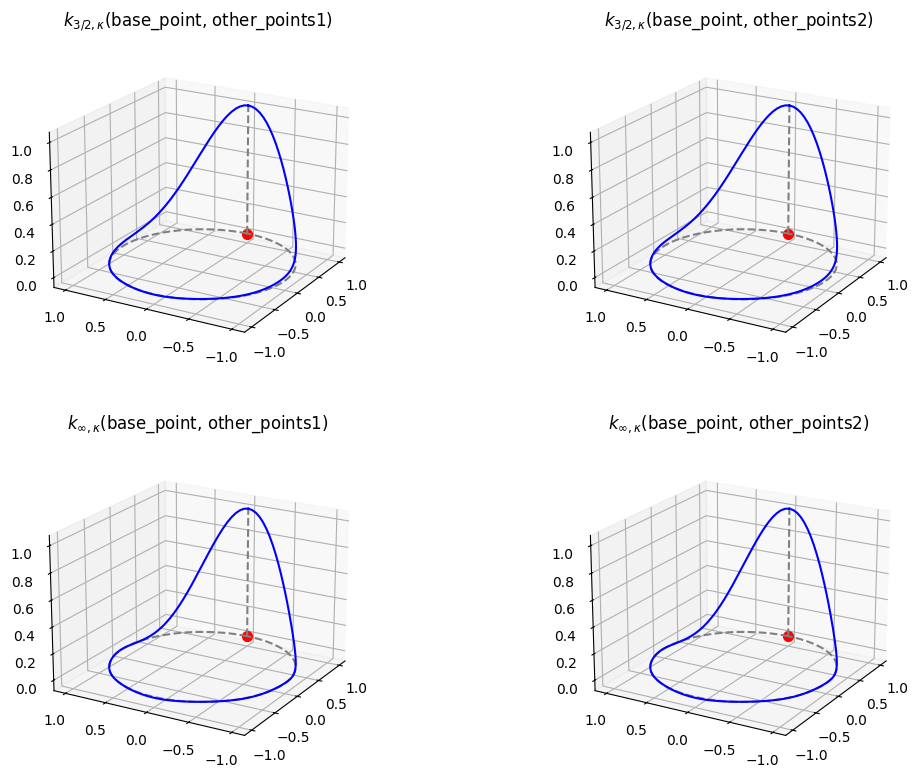

In [12]:
x_circle = np.cos(angles)
y_circle = np.sin(angles)
z_circle = np.zeros_like(angles) # z=0 for the circle

# Red ball position
red_ball_position = (x_circle[0], y_circle[0], z_circle[0])


def plot_kernel(ax, values, title):
    # Draw the unit circle
    ax.plot(x_circle, y_circle, z_circle, linestyle='dashed', color='gray')
    # Draw the red ball
    ax.scatter(*red_ball_position, color="r", s=50)
    # Draw the vertical dashed line
    ax.plot([1, 1], [0, 0], np.linspace(0, values[0, 0], 2), linestyle='dashed', color='gray')
    # Plot the new function evaluated only on the unit circle
    ax.plot(x_circle, y_circle, values[0, :], color='b')
    # Set the viewing angle for better visualization
    ax.view_init(elev=20., azim=180+30)
    ax.set_title(title)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12.8, 9.6), nrows=2, ncols=2,
                               subplot_kw=dict(projection='3d',
                                               computed_zorder=False))

plot_kernel(ax1, kernel_vals_32_1,  r'$k_{3/2, \kappa}($base_point, other_points1$)$')
plot_kernel(ax2, kernel_vals_32_2,  r'$k_{3/2, \kappa}($base_point, other_points2$)$')
plot_kernel(ax3, kernel_vals_inf_1, r'$k_{\infty, \kappa}($base_point, other_points1$)$')
plot_kernel(ax4, kernel_vals_inf_2, r'$k_{\infty, \kappa}($base_point, other_points2$)$')


# Display the plot
plt.show()

## Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on the sphere, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

### Defining a Feature Map

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [13]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs and parameters of the kernel.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For the (hyper)sphere, `normalize` follows the standard behavior of `MaternKarhunenLoeveKernel`, being `True` by default.

`feature_map` outputs a tuple.
Its **second** element is $\phi(x)$ evaluated at all inputs $x$.
Its first element is either `None` for determinstic feature maps, or contains the updated `key` for randomized feature maps which take `key` as a keyword argument.
For `default_feature_map` on a `SpecialUnitary` space, the first element is `key` since the feature map is *random*.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [14]:
# xs are random points from above
key, embedding = feature_map(xs, params_32, key=key)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (10, 3, 3)):
[[[-0.24870157+0.29658916j -0.5727367 -0.11896851j
    0.13530366-0.69978174j]
  [ 0.5363398 +0.02093302j -0.65531723+0.08089576j
    0.33398574+0.40542589j]
  [-0.11099553+0.74146059j  0.29052499+0.37071498j
    0.44367674+0.13868223j]]

 [[-0.40611116+0.68674043j -0.24739267+0.08064182j
    0.53529265+0.09600445j]
  [ 0.26710651-0.26169472j -0.83907273+0.34164848j
    0.06551645+0.18737889j]
  [ 0.45063037+0.1434j      0.32339163+0.08333599j
    0.15110962+0.80125374j]]

 [[-0.13732798+0.60690315j -0.52886472-0.48536215j
   -0.28540059-0.12681398j]
  [ 0.3977959 -0.4922283j  -0.10684889-0.65678461j
   -0.09403321+0.38450588j]
  [ 0.28915018+0.35870808j  0.04449183-0.19990863j
    0.86256719+0.04189913j]]

 [[ 0.38533066-0.816148j    0.22140522-0.1918158j
   -0.25677676+0.18350706j]
  [ 0.03489247-0.16093316j  0.2272763 -0.38032158j
    0.55442717-0.68497775j]
  [-0.02006891+0.39737009j  0.36597823-0.76416447j
   -0.19967803+0.28971629j]]

 [[-0.04247357+0.181

### Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.
Since we are going to compute each of the two samples at two different sets of inputs, `other_points1` and `other_points2`, we make sure the randomness if fixed by using the `make_deterministic` function.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples and kernel parameters.
Additionally, it takes in the keyword argument `key` that specifies randomness in the JAX style.
**However**, in our specific case, this keyword argument is not needed as it is automatically supplied by the `make_deterministic` wrapper.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [15]:
from geometric_kernels.sampling import sampler
from geometric_kernels.utils.utils import make_deterministic

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

sample_paths = make_deterministic(sampler(feature_map, s=2), key)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[ 0.20908269 -0.75934849]
 [ 0.2540385   0.67924155]
 [ 0.66145639 -0.80478104]
 [-0.15058522  0.50189427]
 [-0.80955715 -0.40000388]
 [-0.78663168  1.60778115]
 [-0.98067101 -1.50162492]
 [ 0.646123    0.93331864]
 [-1.18764139 -1.95260521]
 [ 0.94616542  1.49216615]]


#### Visualizing Samples
Here we visualize samples as functions on the sphere.

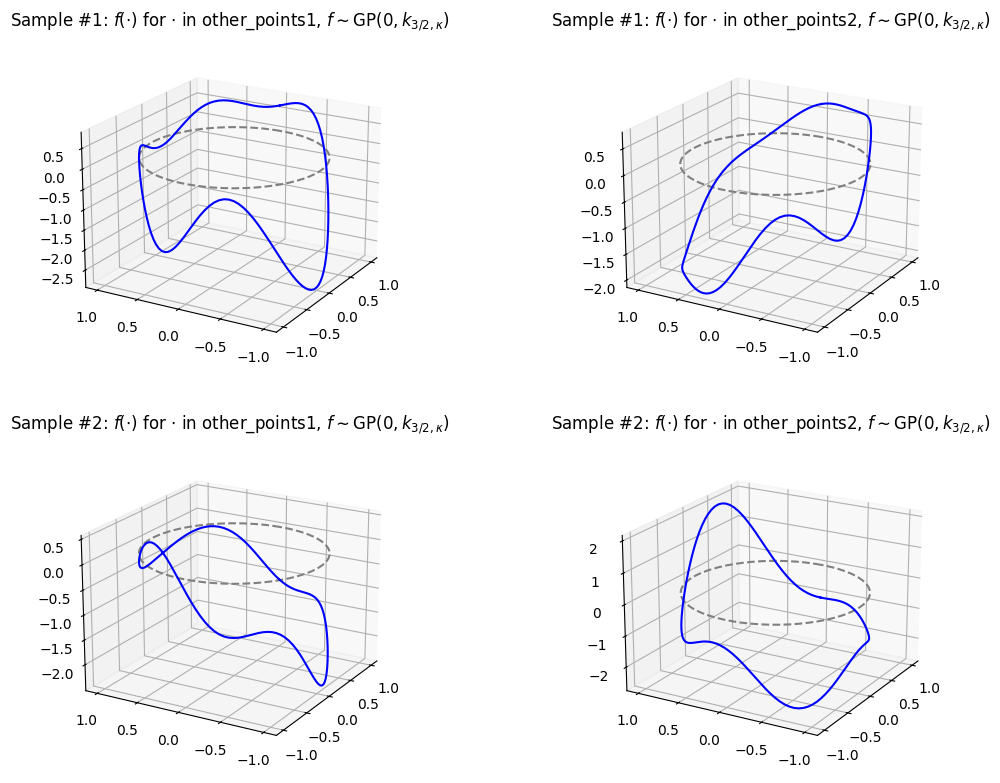

In [16]:
key, samples_other_points1 = sample_paths(other_points1, params_32)
key, samples_other_points2 = sample_paths(other_points2, params_32)

sample1_other_points1 = samples_other_points1[:, 0]
sample2_other_points1 = samples_other_points1[:, 1]
sample1_other_points2 = samples_other_points2[:, 0]
sample2_other_points2 = samples_other_points2[:, 1]

x_circle = np.cos(angles)
y_circle = np.sin(angles)
z_circle = np.zeros_like(angles) # z=0 for the circle

def plot_sample(ax, values, title):
    # Draw the unit circle
    ax.plot(x_circle, y_circle, z_circle, linestyle='dashed', color='gray')
    # Plot the new function evaluated only on the unit circle
    ax.plot(x_circle, y_circle, values, color='b')
    # Set the viewing angle for better visualization
    ax.view_init(elev=20., azim=180+30)
    ax.set_title(title)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12.8, 9.6), nrows=2, ncols=2,
                               subplot_kw=dict(projection='3d',
                                               computed_zorder=False))

plot_sample(ax1, samples_other_points1[:, 0], r'Sample #1: $f(\cdot)$ for $\cdot$ in other_points1, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')
plot_sample(ax2, samples_other_points2[:, 0], r'Sample #1: $f(\cdot)$ for $\cdot$ in other_points2, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')
plot_sample(ax3, samples_other_points1[:, 1], r'Sample #2: $f(\cdot)$ for $\cdot$ in other_points1, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')
plot_sample(ax4, samples_other_points2[:, 1], r'Sample #2: $f(\cdot)$ for $\cdot$ in other_points2, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')


# Display the plot
plt.show()

## Citation

If you are using Lie groups and GeometricKernels, please consider citing

```
@article{mostowsky2024,
      title = {The GeometricKernels Package: Heat and Matérn Kernels for Geometric Learning on Manifolds, Meshes, and Graphs},
      author = {Peter Mostowsky and Vincent Dutordoir and Iskander Azangulov and Noémie Jaquier and Michael John Hutchinson and Aditya Ravuri and Leonel Rozo and Alexander Terenin and Viacheslav Borovitskiy},
      year = {2024},
      journal = {arXiv:2407.08086},
}
```

```
@article{azangulov2024a,
  title = {Stationary Kernels and Gaussian Processes on Lie Groups and their Homogeneous Spaces I: the compact case},
  author = {Azangulov, Iskander and Smolensky, Andrei and Terenin, Alexander and Borovitskiy, Viacheslav},
  journal = {Journal of Machine Learning Research},
  year = {2024},
  volume = {25},
  number = {280},
  pages = {1--52},
}
```